In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Use ARIMA model to forecast quarterly earnings of Johnson and Johnson

We are now going to apply the general modeling procedure to forecast the quarterly earnings per share (EPS) of Johnson & Johnson. We’ll use the same dataset that was introduced in chapters 1 and 2. We will forecast 1 year’s quarterly EPS, meaning that we must forecast four timesteps into the future, since there are four quarters in a year. The dataset covers the period between 1960 and 1980.

In [24]:
df = pd.read_csv('../data/jj.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


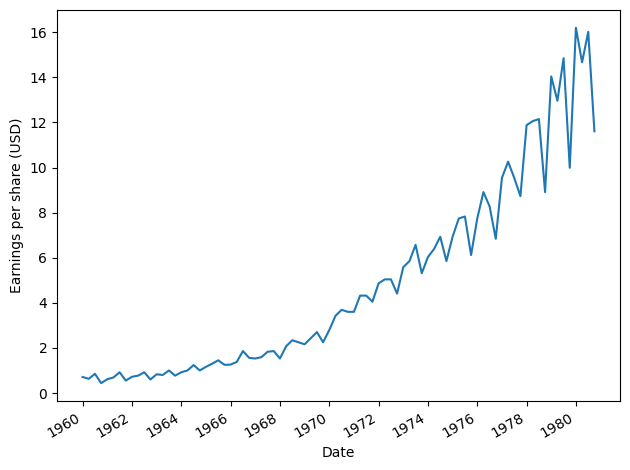

In [25]:
# visualize the time series
fig, ax = plt.subplots()

ax.plot(df.date, df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

#plt.savefig('figures/CH07_F02_peixeiro.png', dpi=300)

## check if the data is stationary

In [26]:
# p-value of 1.0 indicates that the series is not stationary
ad_fuller_result = adfuller(df['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.742016573457468
p-value: 1.0


We need to determine how many times the series must be differenced to become stationary. This will then set the order of integration d. We can apply a first-order differencing and test for stationarity.

p-value of 0.90 shows the differenced series is not stationary

In [27]:
eps_diff = np.diff(df['data'], n=1) # Apply first-order differencing.

ad_fuller_result = adfuller(eps_diff) # Test for stationarity.

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.40740976363804093
p-value: 0.9088542416911314


In [28]:
# differencing again to see if the series becomes stationary

eps_diff2 = np.diff(eps_diff, n=1) # Take the differenced series and difference it again

ad_fuller_result = adfuller(eps_diff2) # Test for stationarity

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.5851628747931485
p-value: 0.006051099869603805


This results in an ADF statistic of –3.59 and a p-value of 0.006. Now that we have a p-value smaller than 0.05 and a large negative ADF statistic, we can reject the null hypothesis and conclude that our series is stationary. It took two rounds of differencing to make our data stationary, which means that our order of integration is 2, so d = 2.

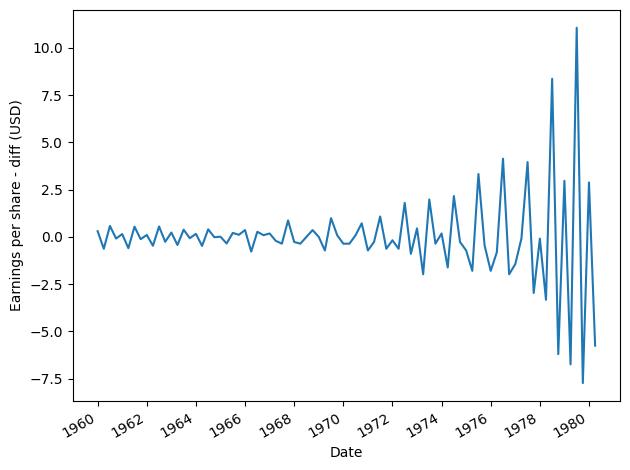

In [29]:
# visualize differenced EPS
fig, ax = plt.subplots()

ax.plot(df['date'][2:], eps_diff2)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH07_F01_peixeiro.png', dpi=300)

Before we move on to fitting different combinations of ARIMA(p,d,q) models, we must separate our data into train and test sets. We will hold out the last year of data for testing. This means that we will fit the model with data from 1960 to 1979 and predict the quarterly EPS in 1980 to evaluate the quality of our model against the observed values in 1980. In figure below the testing period is the shaded area.

In [33]:
train = df['data'][:-4]
test=df['data'][-4:]
test

80    16.20
81    14.67
82    16.02
83    11.61
Name: data, dtype: float64

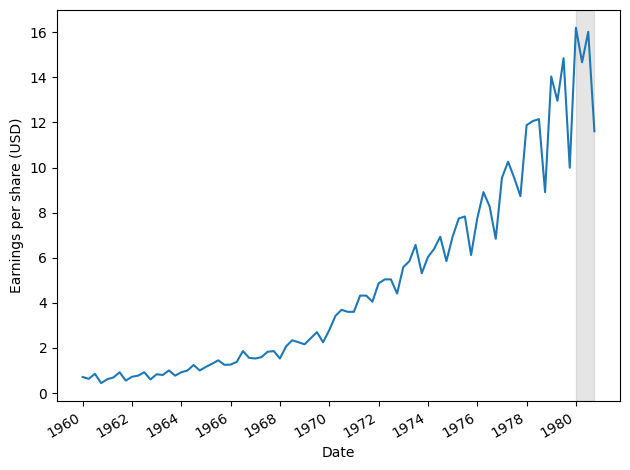

In [34]:
# visualize train and test data set

fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

## define the optimize_ARIMA function
To fit the many ARIMA(p,d,q) models, we’ll define the optimize_ARIMA function. It is almost identical to the optimize_ARMA function that we defined in chapter 6, only this time we’ll add the order of integration d as an input to the function. The remainder of the function stays the same, as we fit the different models and order them by ascending AIC in order to select the model with the lowest AIC. The optimize_ARIMA function is shown in the following cell.

In [35]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

## define a list of possible values for the orders p and q.

In [19]:
ps = range(0, 4, 1)    # Create a list of possible values for p from 0 inclusively to 4 exclusively, with steps of 1.
qs = range(0, 4, 1)    # Create a list of possible values for q from 0 inclusively to 4 exclusively, with steps of 1.
d = 2                  # Set d to 2, as the series needed to be differenced twice to become stationary.

order_list = list(product(ps, qs))     # Generate a list containing all unique combinations of (p,q).

## run the optimize_ARIMA

We can now run the optimize_ARIMA function using the training set. The function returns a DataFrame with the model that has the lowest AIC at the top.

In [18]:
train = df['data'][:-4]

result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",115.272290
1,"(3, 1)",115.624980
2,"(3, 2)",115.672007
3,"(3, 0)",154.430820
4,"(0, 3)",194.654716
5,"(0, 2)",209.274599
6,"(2, 3)",220.666933
7,"(1, 3)",228.267779
8,"(1, 2)",228.935821
9,"(2, 2)",229.974649


The returned DataFrame shows that a value of 3 for both p and q results in the lowest AIC. Therefore, an ARIMA(3,2,3) model seems to be the most suitable for this situation. Now let’s assess the validity of the model by studying its residuals.

In [36]:
# fit an ARIMA(3,2,3) model on the training set

model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   80
Model:               SARIMAX(3, 2, 3)   Log Likelihood                 -50.636
Date:                Mon, 04 Nov 2024   AIC                            115.272
Time:                        11:07:53   BIC                            131.769
Sample:                             0   HQIC                           121.876
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0008      0.036    -27.597      0.000      -1.072      -0.930
ar.L2         -0.9890      0.039    -25.126      0.000      -1.066      -0.912
ar.L3         -0.9762      0.026    -38.059      0.0

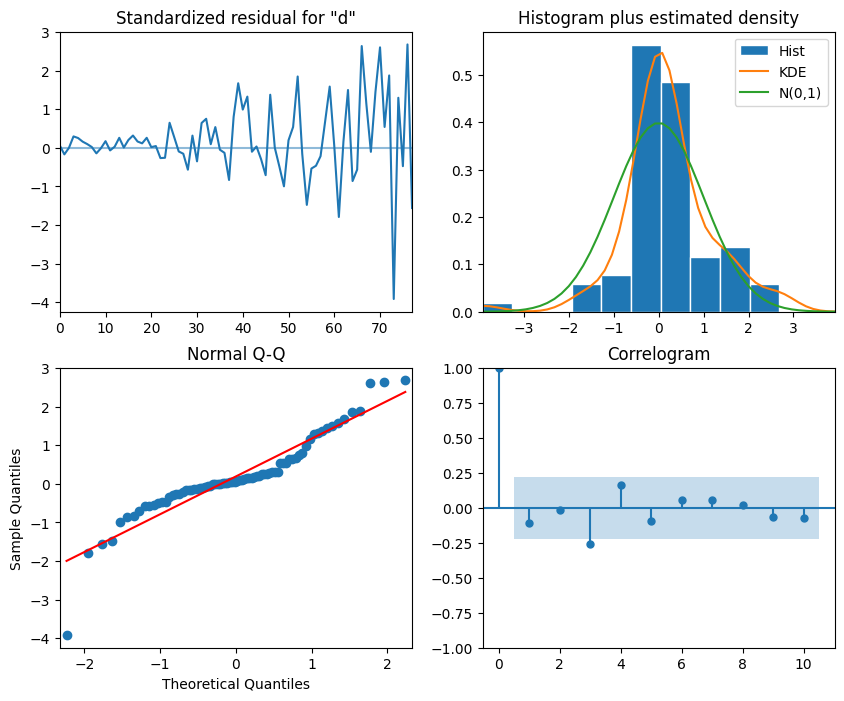

In [37]:
# Display the residuals’ diagnostics.
model_fit.plot_diagnostics(figsize=(10,8));

#plt.savefig('figures/CH07_F07_peixeiro.png', dpi=300)

In figure above, the top-left plot shows the residuals over time. While there is no trend in the residuals, the variance does not seem to be constant, which is a discrepancy in comparison to white noise. At the top right is the distribution of the residuals. We can see it is fairly close to a normal distribution. The Q-Q plot leads us to the same conclusion, as it displays a line that is fairly straight, meaning that the residuals’ distribution is close to a normal distribution. Finally, by looking at the correlogram at the bottom right, we can see that a coefficient seems to be significant at lag 3. However, since it is not preceded by any significant autocorrelation coefficients, we can assume that this is due to chance. Therefore, we can say that the correlogram shows no significant coefficients after lag 0, just like white noise.

Thus, from a qualitative standpoint, it seems that our residuals are close to white noise, which is a good sign, as it means that the model’s errors are random.

In [39]:
# Running the Ljung-Box test on the first 10 lags of the model’s residuals

residuals = model_fit.resid

result = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(result['lb_pvalue'])

1     0.201770
2     0.441546
3     0.063529
4     0.056702
5     0.081261
6     0.122718
7     0.172463
8     0.242979
9     0.299806
10    0.350167
Name: lb_pvalue, dtype: float64


The result returns a list of p-values that are all larger than 0.05. Therefore, we do not reject the null hypothesis, and we conclude that the residuals are not correlated, just like white noise.

## develop a baseline model
As a benchmark for our model, we will use the naive seasonal method. This means that we’ll take the EPS of the first quarter of 1979 and use it as a forecast for the EPS of the first quarter of 1980. Then the EPS of the second quarter of 1979 will be used as a forecast for the EPS of the second quarter of 1980, and so on. Remember that we need a benchmark, or a baseline model, when modeling to determine whether the model we develop is better than a naive method. The performance of a model must always be assessed relative to a baseline model.

In [40]:
test = df.iloc[-4:]
test['naive_seasonal'] = df['data'].iloc[76:80].values
test

,date,data,naive_seasonal
80,1980-01-01,16.20,14.04
81,1980-04-01,14.67,12.96
82,1980-07-02,16.02,14.85
83,1980-10-01,11.61,9.99


In [41]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

,date,data,naive_seasonal,ARIMA_pred
80,1980-01-01,16.20,14.04,15.862706
81,1980-04-01,14.67,12.96,14.380710
82,1980-07-02,16.02,14.85,16.366496
83,1980-10-01,11.61,9.99,11.678532


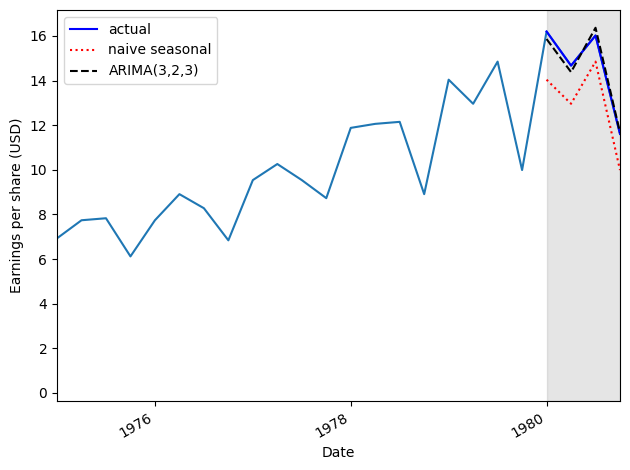

In [43]:
# visualize our forecasts to see how close the predictions from each method are to the observed values

fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH07_F08_peixeiro.png', dpi=300)

In [44]:
# create a function to measure the mean absolute percentage error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [45]:
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA)

11.561658552433654 1.7018071955832357


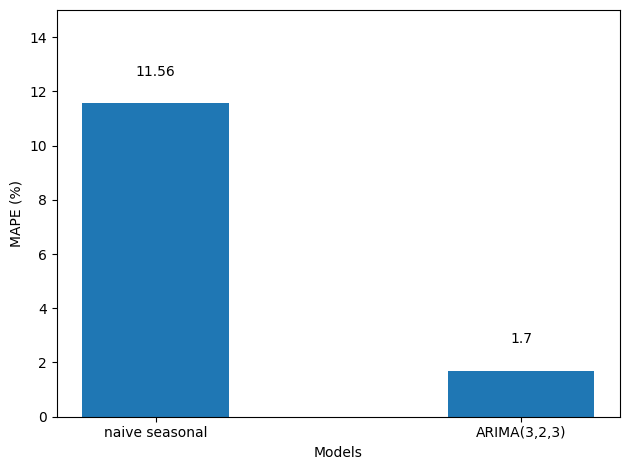

In [47]:
# visualize the mape for both models

fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

#plt.savefig('figures/CH07_F09_peixeiro.png', dpi=300)